### Import section

In [24]:
import numpy as np
import pandas as pd 

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [25]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
# !pip install visualkeras
import tensorflow as tf
#import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
#from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [27]:
# General parameters
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# pip install opencv-python
import cv2
import os

folder_path = "/kaggle/input/Training"             # base/root directory

no_tumor = os.listdir(folder_path + '/notumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
#craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [29]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/notumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [30]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [31]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [32]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [33]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(5712, 240, 240, 3) (5712,)


### Deep Feature Extraction

In [34]:
from tensorflow.keras.applications import DenseNet201

model = DenseNet201(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

from tensorflow.keras.applications.densenet import preprocess_input

dataset = preprocess_input(np.array(dataset))
model.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 240, 240, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 246, 246, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 120, 120, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 120, 120, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 120, 120, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 122, 122, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 60, 60, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 60, 60, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 60, 60, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 60, 60, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 60, 60, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 60, 60, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 60, 60, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 60, 60, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

subdirectories = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Create a generator for the images in the subdirectories
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
#     class_mode=None,
    shuffle=False,
    classes=subdirectories)

Found 5712 images belonging to 4 classes.


In [36]:
features = model.predict(generator, verbose=1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 252ms/step


In [37]:
 print(len(features))

5712


In [38]:
print("Number of extracted deep features:", features.shape[1])

Number of extracted deep features: 7


In [39]:
#np.save('extracted_features.npy', features)

In [40]:
features.shape

(5712, 7, 7, 1920)

In [41]:
from tensorflow.keras.layers import Input

# Flatten the features to use them for classification
features_flatten = np.reshape(features, (features.shape[0], -1))

# Define the labels for the images in the subdirectories
labels = generator.classes

In [42]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

In [43]:
print(train_features.max(), train_features.min())
print(test_features.max(), test_features.min())

# train_features = train_features/255
# test_features = test_features/255
# print(train_features.max(), train_features.min())
# print(test_features.max(), test_features.min())

42.81535 0.0
40.09885 0.0


### SVM

In [44]:
from sklearn.svm import SVC

# Initialize and train an SVC model
svc_model = SVC(kernel='linear')  # You can use other kernels as well
svc_model.fit(train_features, train_labels)

# Predict the labels of the testing set using the trained SVC model
predicted_labels = svc_model.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

     notumor       0.99      0.99      0.99       346
      glioma       0.98      0.97      0.97       251
  meningioma       0.92      0.94      0.93       247
   pituitary       0.98      0.97      0.98       299

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143



In [45]:
print(matrix)

[[341   0   5   0]
 [  0 243   8   0]
 [  4   6 232   5]
 [  0   0   8 291]]


In [46]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.9599020172332955

In [47]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['notumor', 'glioma', 'meningioma', 'pituitary'],

                     columns = ['notumor', 'glioma', 'meningioma', 'pituitary'])

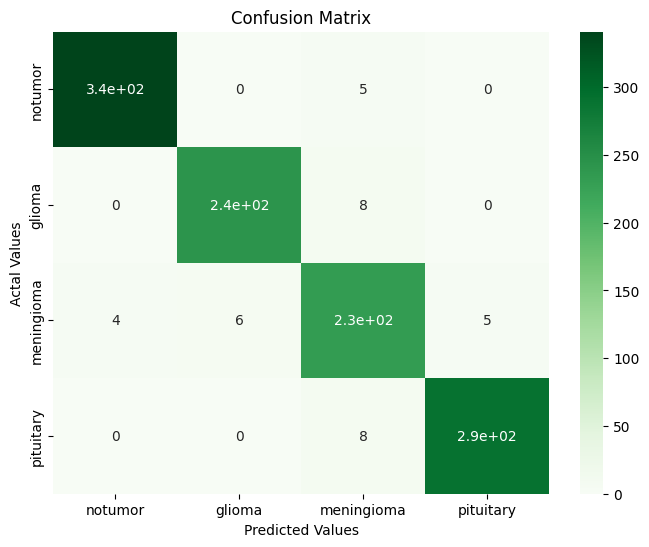

In [48]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [49]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.968503937007874

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.968503937007874

In [51]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.968503937007874

In [52]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.968503937007874

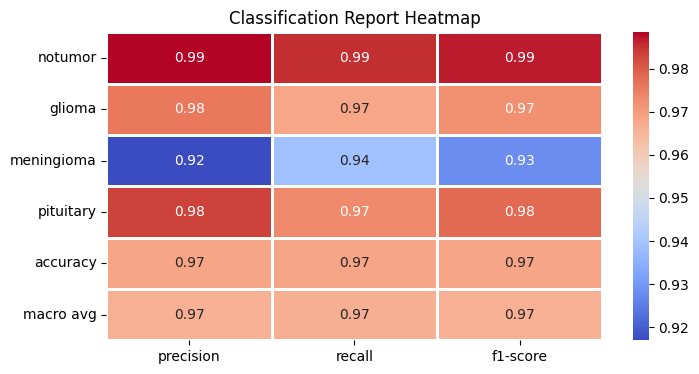

In [53]:
from sklearn.metrics import classification_report
import pandas as pd

class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']

# Generate classification report
report_dict = classification_report(test_labels, predicted_labels, target_names=class_names, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).T

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="coolwarm", linewidths=1)
plt.title("Classification Report Heatmap")
plt.show()

****HyperParameter Tuning

In [54]:
from sklearn.utils import resample

# Subsample training data (e.g., 30% of the original data)
train_features_sub, train_labels_sub = resample(
    train_features, train_labels, n_samples=int(0.3 * len(train_features)), random_state=42
)

In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# Convert features to float32 to save memory
train_features_sub = train_features_sub.astype('float32')
test_features = test_features.astype('float32')

# Define hyperparameter space
param_dist = {
    'C': uniform(0.1, 10),  # Range for regularization parameter
    'kernel': ['linear', 'rbf'],  # Test both linear & rbf
    'gamma': ['scale', 'auto']  # Only for 'rbf' kernel
}

# Initialize SVC model
svc = SVC()

# RandomizedSearchCV with limited iterations
random_search = RandomizedSearchCV(
    svc, 
    param_distributions=param_dist,
    n_iter=5,  # Reduce for memory efficiency
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Train with subsampled dataset
random_search.fit(train_features_sub, train_labels_sub)

# Print best parameters
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'C': 5.345855790735243, 'gamma': 'scale', 'kernel': 'rbf'}


In [56]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Define the best parameters from RandomizedSearchCV
best_params = {'C': 5.345855790735243, 'gamma': 'scale', 'kernel': 'rbf'}

# Train SVC on the full dataset using best hyperparameters
svc_model = SVC(**best_params)
svc_model.fit(train_features, train_labels)

# Predict on test set
predicted_labels = svc_model.predict(test_features)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(test_labels, predicted_labels))
print("Confusion Matrix:\n", confusion_matrix(test_labels, predicted_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       346
           1       0.98      0.96      0.97       251
           2       0.91      0.96      0.93       247
           3       0.99      0.98      0.99       299

    accuracy                           0.97      1143
   macro avg       0.97      0.97      0.97      1143
weighted avg       0.97      0.97      0.97      1143

Confusion Matrix:
 [[340   0   6   0]
 [  0 240  11   0]
 [  4   4 236   3]
 [  0   0   5 294]]


In [57]:
accuracy_score(test_labels, predicted_labels)

0.9711286089238845

In [58]:
precision_score(test_labels, predicted_labels,average='micro')

0.9711286089238845

In [59]:
import joblib

# Save the trained SVC model
joblib.dump(svc_model, "svm_brain_tumor_model.pkl")


['svm_brain_tumor_model.pkl']

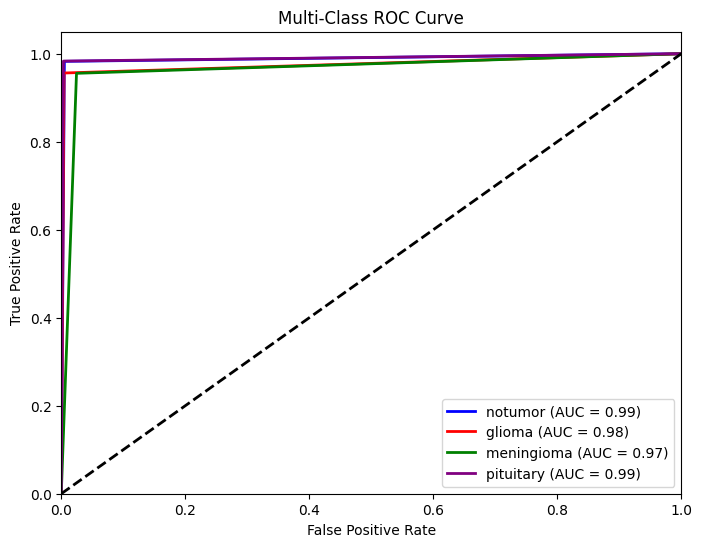

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
num_classes = len(class_names)
y_test_bin = label_binarize(test_labels, classes=np.arange(num_classes))
y_pred_bin = label_binarize(predicted_labels, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))

colors = cycle(["blue", "red", "green", "purple"])

for i, color in zip(range(num_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal baseline
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()
